
## Trading Gold ETF with predictions with Linear Regression vs. LSTM

*Author: Florian Bozhdaraj*

We will create a linear regression and LSTM Model that take information from the past Gold ETF (GLD) prices and return a prediction of the Gold ETF price the next day. We will compare both methods to find out which fits better for this use case.

Note that, based on Brownian Motion (we will not cover that here), the future variations of stock price are independent of the past. So, it is impossible to predict the exact stock price, but possible to predict and capture the upward and downward trends.

### Initial Data Exploration

Import and install relevant packages

In [110]:
git remote add origin https://github.com/florijanib/Finance-Applications.git
git push -u origin master

# yahoo finance is used to fetch data
! pip install yfinance
import yfinance as yf


# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

SyntaxError: ignored

Then, we read the past 12 years of daily Gold ETF price data and store it in Df.

In [41]:
# Read data from yahoo
Df = yf.download('GLD', '2018-10-04', '2020-05-07', auto_adjust=True)

print(Df.head(5))
print(Df.info())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close    Volume
Date                                                                
2018-10-04  113.830002  114.190002  113.260002  113.480003   6616200
2018-10-05  113.809998  114.099998  113.570000  113.800003   7994400
2018-10-08  112.250000  112.589996  111.900002  112.540001  12111600
2018-10-09  112.370003  112.669998  111.970001  112.599998   8352300
2018-10-10  112.470001  112.959999  112.250000  112.879997  10571300
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 399 entries, 2018-10-04 to 2020-05-06
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    399 non-null    float64
 1   High    399 non-null    float64
 2   Low     399 non-null    float64
 3   Close   399 non-null    float64
 4   Volume  399 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 18.7 KB
None


Our data set includes 5 rows that represent the performance of the gold price over the past 12 years. The prices are float32 types because they represent the ticker and this is shown up to six digits after the decimal point.

Open: Open prices representes the value of the gold price when the market opens. \
High: Represents the highest price of that day.\
High: Represents the highest price of that day.\
Close: Represents the highest price of that day.

The volume row represents the total volume of the stock index traded on that day and must therefore be an integer from which the integer type is derived.

The data set used for this comprises 3160 columns and 5 rows (as mentioned above), which results in a memory usage of 148.3 KB and is not particularly large.
We only need the close prices for our later application and remove the columns which are not relevant. Then, we plot the Gold ETF close price.

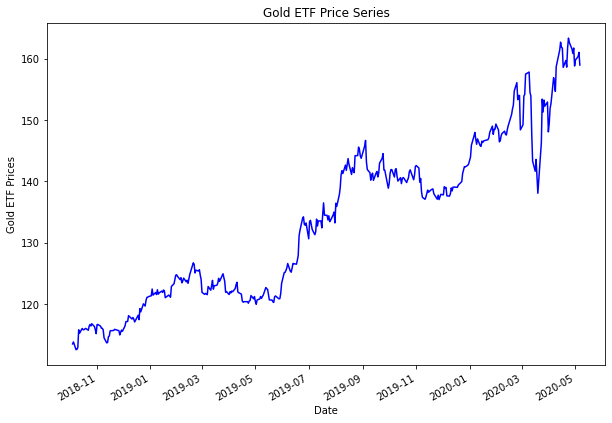

In [42]:
# Only keep close prices columns
Df = Df[['Close']]
# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='b')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

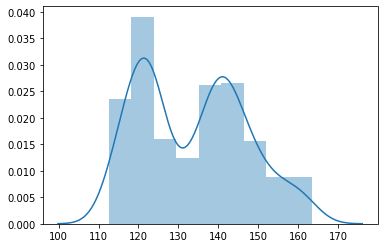

In [43]:
sns.distplot(Df)

In [44]:
Df.mean()

Close    133.657042
dtype: float64

In [45]:
Df.std()

Close    13.254773
dtype: float64

We have an average of 133.7, which is not really meaningful given this high fluctuation. The standard deviation is 13. With this distribution, the values are relatively difficult to estimate because we have two shifted normal distributions due the shift in the financial timeseries. We remedy this situation by making the time series (somewhat) stationary. But more on that in the ETL-process.

In [46]:
Df.shape

(399, 1)

In [47]:
#Df.to_csv(r'C:\Users\fbozh\OneDrive - ZHAW\Specialization Advanced Data Science IBM\Applied Data Science Capstone\Gold_ETF_close_price_12_Y.csv')

### Extract Transform Load

#### Stationarity
We assume throughout that the data-process is stationary. In practice ones requires
weakstationarity, that is

$E[x_{t-1}] = 0$ \
$Var[x_{t-1}] = sigma^2$ \
$Cov[x_{t-1}; x_{t-m}] = R(m)$ does not depend on t.



Long episodes of positive growth moving average: non-stationary can be observed, followed by shorter systemic downward movements dot-com crisis, major recession, etc. Typically, trends can be reduced or eliminated by using differences. This gives the relative growth. Large seasonal Fluctuations in the original data can be mitigated by using log-transformed ones.
Since we have only positive data, one can form differences in the log returns to make the time series sationary.

In [63]:
Df['Close'] = (np.log(Df['Close']/Df['Close'].shift(1)))
Df.head()

KeyError: ignored

#### Define explanatory variables

The features which we want to use to predict the Gold ETF price are the moving averages for past 3 days and 9 days. We drop the NaN values using dropna() function and store the feature variables in X.

#### Define dependent variable
Similarly, the dependent variable depends on the values of the explanatory variables. Simply put, it is the Gold ETF price which we are trying to predict. We store the Gold ETF price in y.


In [49]:
Df['S_3'] = Df['Close'].rolling(window=3).mean()
Df['S_9'] = Df['Close'].rolling(window=9).mean()
Df['y'] = Df['Close'].shift(-1)
Df = Df.drop('Close', axis=1)
Df = Df.dropna()

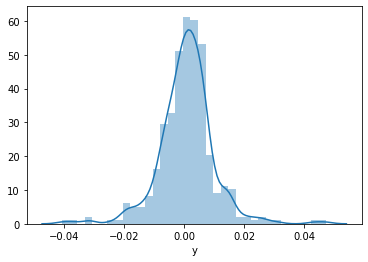

In [50]:
sns.distplot(Df['y'])

In [51]:
Df.mean()

S_3    0.000840
S_9    0.000884
y      0.000814
dtype: float64

In [52]:
Df.std()

S_3    0.005639
S_9    0.002845
y      0.009291
dtype: float64

In [53]:
print(Df.shape)
print(Df.head())

(389, 3)
                 S_3       S_9         y
Date                                    
2018-10-17  0.001616  0.002239  0.001122
2018-10-18 -0.000230  0.002051  0.000776
2018-10-19  0.000604  0.003374 -0.002589
2018-10-22 -0.000230  0.003027  0.005860
2018-10-23  0.001349  0.003402  0.002317


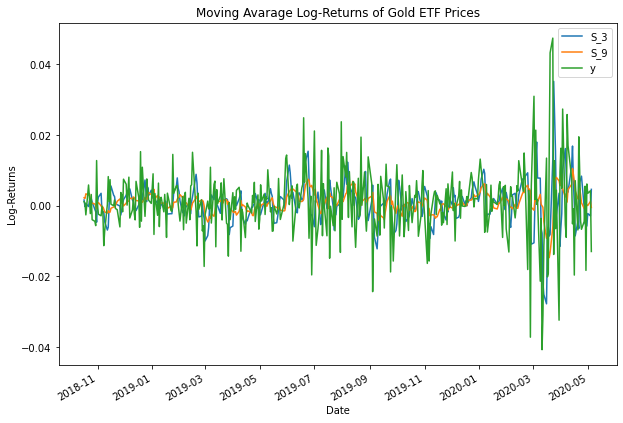

In [64]:
# Plot the closing price of GLD
Df.plot(figsize=(10, 7))
plt.ylabel("Log-Returns")
plt.title("Moving Avarage Log-Returns of Gold ETF Prices")
plt.show()

In [65]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))
print(t)

311


In [66]:
# Train dataset
train = Df[:t]

# Test dataset
test = Df[t:]

In [67]:
print(train.shape)
print(train.head())
print(test.shape)
print(test.head())

(311, 3)
                 S_3       S_9         y
Date                                    
2018-10-17  0.001616  0.002239  0.001122
2018-10-18 -0.000230  0.002051  0.000776
2018-10-19  0.000604  0.003374 -0.002589
2018-10-22 -0.000230  0.003027  0.005860
2018-10-23  0.001349  0.003402  0.002317
(78, 3)
                 S_3       S_9         y
Date                                    
2020-01-14 -0.000777  0.002148  0.005817
2020-01-15 -0.000841  0.001981 -0.001571
2020-01-16  0.001118  0.000342  0.001844
2020-01-17  0.002030 -0.000612  0.001091
2020-01-21  0.000455 -0.000927  0.000341


### Model Training

In [68]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

#train = pd.read_csv(r'C:\Users\fbozh\OneDrive - ZHAW\Specialization Advanced Data Science IBM\Applied Data Science Capstone\train.csv')
#test = pd.read_csv(r'C:\Users\fbozh\OneDrive - ZHAW\Specialization Advanced Data Science IBM\Applied Data Science Capstone\test.csv')


In [69]:
print(train.head())
train.shape

print(test.head())
test.shape

                 S_3       S_9         y
Date                                    
2018-10-17  0.001616  0.002239  0.001122
2018-10-18 -0.000230  0.002051  0.000776
2018-10-19  0.000604  0.003374 -0.002589
2018-10-22 -0.000230  0.003027  0.005860
2018-10-23  0.001349  0.003402  0.002317
                 S_3       S_9         y
Date                                    
2020-01-14 -0.000777  0.002148  0.005817
2020-01-15 -0.000841  0.001981 -0.001571
2020-01-16  0.001118  0.000342  0.001844
2020-01-17  0.002030 -0.000612  0.001091
2020-01-21  0.000455 -0.000927  0.000341


(78, 3)

## Create a linear regression model

We will now create a linear regression model.

To break it down further, regression explains the variation in a dependent variable in terms of independent variables. The dependent variable - ‘y’ is the variable that we want to predict. The independent variables - ‘x’ are the explanatory variables that we use to predict the dependent variable. The following regression equation describes that relation:

$ Y = m1 * X1 + m2 * X2 + C $ \
 Gold ETF price $= m1 * $ 3 days moving average $ + m2 * $ 15 days moving average$ + c $

In [70]:
x_train = train[['S_3','S_9']]
y_train = train['y']
print(x_train.head())
x_train.shape

                 S_3       S_9
Date                          
2018-10-17  0.001616  0.002239
2018-10-18 -0.000230  0.002051
2018-10-19  0.000604  0.003374
2018-10-22 -0.000230  0.003027
2018-10-23  0.001349  0.003402


(311, 2)

In [71]:
x_test = test[['S_3','S_9']]
y_test = test['y']
print(x_test.head())
x_test.shape

                 S_3       S_9
Date                          
2020-01-14 -0.000777  0.002148
2020-01-15 -0.000841  0.001981
2020-01-16  0.001118  0.000342
2020-01-17  0.002030 -0.000612
2020-01-21  0.000455 -0.000927


(78, 2)

In [72]:
# Create a linear regression model
linear = LinearRegression().fit(x_train, y_train)

#### Predict the Gold ETF prices

Now, it’s time to check if the model works in the test dataset. We predict the Gold ETF prices using the linear model created using the train dataset. The predict method finds the Gold ETF price (y) for the given explanatory variable X.


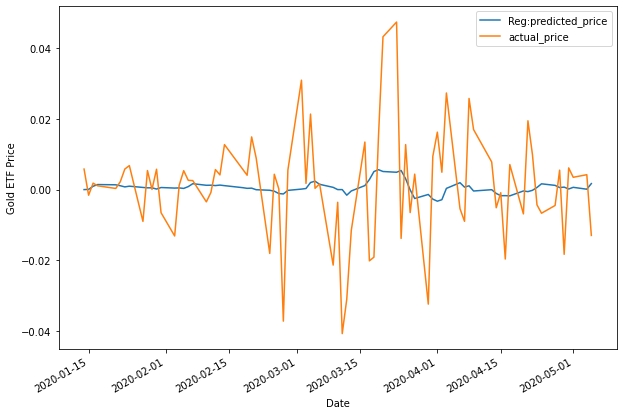

In [73]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(x_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['Reg:predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

## Create the LSTM Model

After we have first built a predictive regression model, we use the same explanatory variable and the same target variable and apply them to an LSTM model and finally compare these two methods.


In [74]:
# import relevant packages 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [75]:
Df_lstm=pd.read_csv(r'C:\Users\fbozh\OneDrive - ZHAW\Specialization Advanced Data Science IBM\Applied Data Science Capstone\Gold_ETF_close_price_12_Y.csv')
Df_lstm = Df
Df_lstm.head()

,S_3,S_9,y
Date,,,
2018-10-17,0.001616,0.002239,0.001122
2018-10-18,-0.000230,0.002051,0.000776
2018-10-19,0.000604,0.003374,-0.002589
2018-10-22,-0.000230,0.003027,0.005860
2018-10-23,0.001349,0.003402,0.002317


In [77]:
print(Df_lstm.head())
print(Df_lstm.shape)

                 S_3       S_9         y
Date                                    
2018-10-17  0.001616  0.002239  0.001122
2018-10-18 -0.000230  0.002051  0.000776
2018-10-19  0.000604  0.003374 -0.002589
2018-10-22 -0.000230  0.003027  0.005860
2018-10-23  0.001349  0.003402  0.002317
(389, 3)


#### We are already scaling the data with the MinMax-Scaler (see next steps), so why the log returns?

Log returns are symmetric compared to percentage change. $ Log(a/b)=log(b/a) $ and this (less skewness), in theory, leads to better results for most models (linear regression, neural networks). Neural networks like LSTM work better if the values are close to zero, but the difference in normalizations is usually not that big! Any returns (log or percentage) are better than raw values because prices change according to previous prices. Their absolute (raw) values have an (almost) negligible influence compared to the previous price.


In [78]:
# take only Close prices
values = np.array(Df_lstm[['S_3', 'S_9', 'y']])
print(values[:10])
print(values.shape)

[[ 1.61601779e-03  2.23906378e-03  1.12206869e-03]
 [-2.29969630e-04  2.05085930e-03  7.76130485e-04]
 [ 6.03940403e-04  3.37418784e-03 -2.58935973e-03]
 [-2.30386852e-04  3.02726120e-03  5.85956273e-03]
 [ 1.34877783e-03  3.40237028e-03  2.31713701e-03]
 [ 1.86244667e-03  8.41324957e-04 -2.23120431e-03]
 [ 1.98183181e-03  1.12248758e-03  3.17361093e-03]
 [ 1.08651454e-03  7.35107581e-04 -3.94713998e-03]
 [-1.00157779e-03  4.88269763e-04 -4.39442787e-03]
 [-1.72265230e-03  9.59755129e-06 -5.62895197e-03]]
(389, 3)


#### Feature scaling

The next step is to scale the returns between (0, 1) to avoid an intensive calculation. It is recommended to do normalization, especially if you are working on RNN with a sigmoid function in the output layer.


In [79]:
# ensure all data is float
values = values.astype('float32')

In [80]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled[0:20])

[[0.46661627 0.6728263  0.4748012 ]
 [0.43727058 0.6653458  0.47087434]
 [0.45052725 0.7179436  0.43267143]
 [0.43726394 0.70415443 0.5285782 ]
 [0.46236795 0.71906376 0.48836687]
 [0.47053376 0.6172709  0.436737  ]
 [0.4724316  0.62844616 0.49808902]
 [0.45819873 0.6130491  0.41725877]
 [0.4250043  0.60323817 0.41218144]
 [0.41354138 0.58421254 0.3981679 ]
 [0.36689654 0.55439806 0.607031  ]
 [0.45548534 0.6073703  0.464011  ]
 [0.47968024 0.6195631  0.4347844 ]
 [0.49677342 0.58307225 0.4298283 ]
 [0.41405228 0.5602976  0.46108574]
 [0.4126867  0.5697706  0.43758   ]
 [0.41399175 0.5462293  0.3338884 ]
 [0.36920542 0.51379377 0.3804638 ]
 [0.3315698  0.50145394 0.4660577 ]
 [0.34486365 0.52786666 0.5555246 ]]


In [82]:
# Split the data into train and test dataset (80% Train, 20% Test)

# Train dataset
train = scaled[:t]

# Test dataset
test = scaled[t:]

In [83]:


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

#### Data reshaping

In [84]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(311, 1, 2) (311,) (78, 1, 2) (78,)


#### Model building

We are building a NN regressor for continuous value prediction using LSTM. 

- First, initialize the model.
- Then, add the 1st LSTM layer with the Dropout layer followed. / Note for the LSTM layer, units is the number of LSTM neurons in the layer. 50 neurons will give the model high dimensionality, enough to capture the upwards and downward trends. return_sequences is True as we need to add another LSTM layer after the current one. input_shape corresponds to the number of time stamps and the number of indicators. For dropout, 20% of 50 neurons will be ignored randomly during each iteration of training.
- Following the above same method, add 2nd, 3rd, and 4th LSTM layer. / add 2nd lstm layer / 3rd lstm layer / add 4th lstm layer
- Note the last LSTM layer, return_sequences is False as we will not add more LSTM layers. 
- Finally, add the output layer. The output dimension is 1 since we are predicting 1 price each time.

In [85]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10600     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

####  Model compiling
Now we compile the RNN by choosing an SGD algorithm and a loss function. For optimizer, we use Adam, a safe choice to start with. The loss function is the mean of squared errors between actual values and predictions.


In [86]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### Model fitting
RNN weights are updated every 26 observations with a batch size of 26.

In [89]:
regressor.fit(train_X, train_y, epochs = 50, batch_size = 10)

Epoch 1/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0076
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 11/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 12/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0073
Epoch 13/50
32/32 [==============================

 #### Model prediction

In [90]:
testPredict = regressor.predict(test_X)

We have predicted the scaled values, so we need to reverse the prediction.

In [91]:
# create empty table with 3 fields
testPredict_dataset_like = np.zeros(shape=(len(testPredict), 3) )

# put the predicted values in the right field
testPredict_dataset_like[:,0] = testPredict[:,0]

# inverse transform and then select the right field
prediction = scaler.inverse_transform(testPredict_dataset_like)[:,0]

print(prediction)

[0.00103475 0.00104268 0.00114418 0.00120113 0.00120239 0.001164
 0.00112056 0.00113623 0.00107529 0.00108661 0.00108765 0.00105765
 0.00108072 0.00108711 0.0011221  0.00111372 0.00115313 0.00122548
 0.0011645  0.00118707 0.00118128 0.0011915  0.00115485 0.00104975
 0.00102396 0.0010311  0.00096747 0.00094037 0.00095663 0.00089516
 0.00089974 0.0010736  0.00111744 0.00107138 0.00120488 0.00121705
 0.00117129 0.00105878 0.00107289 0.00108179 0.00097109 0.00114154
 0.00134609 0.00145534 0.00171526 0.00179468 0.0017287  0.00157949
 0.00150031 0.00125531 0.00090881 0.00071834 0.00082456 0.00075888
 0.0006447  0.00067196 0.00100352 0.00117369 0.00105889 0.00113969
 0.00095133 0.000947   0.00076471 0.00075667 0.00080147 0.00085816
 0.00100948 0.00099949 0.00095738 0.00105678 0.00118598 0.00118678
 0.00113851 0.00113308 0.00108969 0.00112786 0.00106334 0.00121912]


In [92]:
#Calculate/Get the value of RMSE
rmse_Regression = np.sqrt(np.mean(((np.array(predicted_price)- test_y)**2)))
print('RMSE Regression: ',rmse_Regression)

#Calculate/Get the value of RMSE
rmse_LSTM = np.sqrt(np.mean(((prediction- test_y)**2)))
print('RMSE LSTM: ',rmse_LSTM)

RMSE Regression:  0.5046347757636434
RMSE LSTM:  0.5041552948831547


#### Visualization

In [94]:
#Create the data for the graph
#Df=pd.read_csv(r'C:\Users\fbozh\OneDrive - ZHAW\Specialization Advanced Data Science IBM\Applied Data Science Capstone\Df.csv')
Realprices = Df['y']
Realprices_r = np.array(Df['y'])
print(len(Realprices))

389


Get differences out of prediction to get trend

In [95]:
s = pd.Series(np.concatenate([[0],prediction]))
s1 = pd.DataFrame(s.diff())
prediction = np.array(s1.dropna())

In [101]:
prediction[:10]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.]])

In [102]:
#get trading signals out of prediction (1: BUY, 2: SELL)
prediction[prediction > 0] = 1 ; prediction[prediction < 0] = -1
predicted_price[predicted_price > 0] = 1 ; predicted_price[predicted_price < 0] = -1

Predictions_reg = np.append(np.ones(len(x_train)), predicted_price)
Predictions_lstm = np.append(np.ones(len(x_train)), prediction)
Date = np.append(Date_train,Date_test)

print(Predictions_reg)
print(Predictions_lstm)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

In [103]:
Trading_reg = np.cumsum(Predictions_reg*Realprices)
Trading_lstm = np.cumsum(Predictions_lstm*Realprices)
cumulative_prices = np.cumsum(Realprices)

In [105]:
Performance_Df = pd.DataFrame()
Performance_Df['REG'] = Trading_reg
Performance_Df['LSTM'] = Trading_lstm
Performance_Df['REAL'] = cumulative_prices.values
print(Performance_Df.head())

                 REG      LSTM      REAL
Date                                    
2018-10-17  0.001122  0.001122  0.001122
2018-10-18  0.001898  0.001898  0.001898
2018-10-19 -0.000691 -0.000691 -0.000691
2018-10-22  0.005168  0.005168  0.005168
2018-10-23  0.007486  0.007486  0.007486


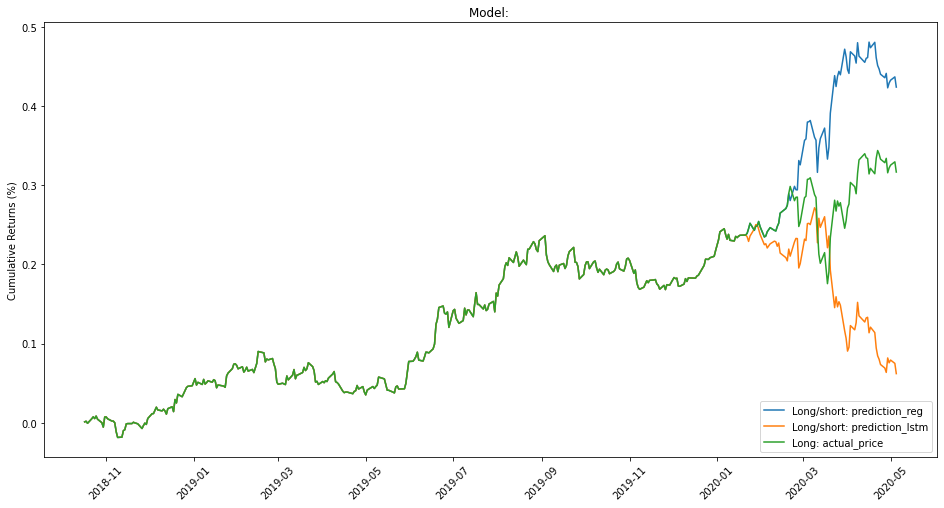

In [106]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model: ')
plt.ylabel('Cumulative Returns (%)')
plt.plot(Performance_Df)
plt.legend(['Long/short: prediction_reg', 'Long/short: prediction_lstm','Long: actual_price'], loc='lower right')
plt.xticks(rotation=45)
plt.show()



#### Performance Analysis

##### Sharpe Ratio: 
The shapre ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

Formula and Calculation of Sharpe Ratio

\begin{aligned} &\textit{SR} = \frac{R_p - R_f}{\sigma_p}\\ &\textbf{where:}\\ &R_{p}=\text{return of portfolio}\\ &R_{f} = \text{risk-free rate}\\ &\sigma_p = \text{standard deviation of the portfolio's excess return}\\ \end{aligned} 


In [107]:
r = Performance_Df[-len(y_test+1):].diff()
sr = r.mean()/r.std() * np.sqrt(250)

We need to annualize the Sharpe ratio, since we calculated it from daily values. There are 252 trading days in the year, so the simple way to annualize it is to multiply the Sharpe ratio by the square root of 252.

$ SR_{ann} = SR* \sqrt{252}$

In [108]:
print('Sharpe Ratios:')
print(round(sr,3))

Sharpe Ratios:
REG     2.541
LSTM   -2.331
REAL    1.083
dtype: float64


##### Hit rate:

How many times did we hit the right trading signal!

Values above 50% (better above 53%) are needed!
Values below 50% mean that one should rather do the opposite. So pretty bad performance!


If the values are +/- 50%, then there is a 50/50 chance. In this case we would have the same success with the coin toss!

In [109]:
r[r > 0] = 1 ; r[r < 0] = -1
differ_RERE = r['REAL'] == r['REG']
differ_RELS = r['REAL'] == r['LSTM']
print('Hitrate REG: ', round(differ_RERE[differ_RERE == True].count()/differ_RERE.count(),4)*100, '%')
print('Hitrate LSTM: ', round(differ_RELS[differ_RELS == True].count()/differ_RELS.count(),4)*100, '%')

Hitrate REG:  69.23 %
Hitrate LSTM:  52.559999999999995 %


Seems like the predictive regression is performing a lot (+25%) better here. The LSTM model also performs well in terms of returns (see Sharpe ratios). But based on the hit rate it was just a coincidence!



LSTM on its own does not seem particularly suitable in this case. It was to be honestly expected. One could try in the future whether the two complement each other e.g. as a hybrid model by taking the residuals from the linear regression model and feeding them into the LSTM as input in order to filter out any non-linear information for the trading signals and thus make the prediction even better.